# **Machine Learning (MSDS680) Course Project**
This projects aims to find the best performing model that can train on the EMNIST letters data.


---


*   Author: Karim Walid
*   Date: 30/03/2025
*   Instructor: Pantelis Kaplanoglou


---



# **Option 01**

In [35]:
# Install the Rapid Deep Neural Networks library
!pip install radnn -q
!pip list | grep "radnn"

from radnn.system.hosts import ColabHost

# Mount to the project folder that is under the lesson folder
ColabHost().detect_workspace(["CS345", "MSDS680"]).change_to_project_dir("MLData")

radnn                              0.0.8
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Current directory is:  /content/gdrive/My Drive/Colab Notebooks/MSDS680/MLData


Host: (colab)-172.28.0.12

In [36]:
import os
os.environ["TF_USE_LEGACY_KERAS"]="1"   # Use Keras 2.x. We set this before the first import of tensorflow

import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from radnn import mlsys, FileSystem
from radnn.experiment import MLExperimentConfig
#from mllib.visualization import CPlot, CPlotTrainingLogs, CAutoMultiImagePlot
oFileSys = FileSystem(config_folder="MLConfig", model_folder="MLModels", dataset_folder="MLData")
# __________ | Settings | __________
IS_PLOTING_DATA             = True
IS_RETRAINING               = False
RANDOM_SEED             = 2022
mlsys.filesys = FileSystem("MLConfig", model_folder="MLModels", dataset_folder="MLData")

In [37]:
import numpy as np
import gzip
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/MSDS680/MLData'

In [38]:
import numpy as np
from enum import Enum


# =========================================================================================================================
class SetType(Enum):
  TRAINING_SET      = 1
  VALIDATION_SET    = 2
  UNKNOWN_TEST_SET  = 3
# =========================================================================================================================


# =========================================================================================================================
class CDataSet(object):
  # --------------------------------------------------------------------------------------
  # Constructor
  def __init__(self):
    # ................................................................
    # // Fields \\
    self.Samples            = None
    self.Labels             = None
    self.SampleCount        = 0
    self.FeatureCount       = None
    self.ClassCount         = None

    self.TSSamples      = None
    self.TSLabels       = None
    self.TSSampleCount  = 0

    self.VSSamples      = None
    self.VSLabels       = None
    self.VSSampleCount  = 0

    self.USSamples      = None
    self.USLabels       = None
    self.USSampleCount  = 0
    # ................................................................
  # --------------------------------------------------------------------------------------
  # Method
  def DebugPrint(self):
    print("Shape of sample tensor", self.Samples.shape)
    print('.'*80)

    print("Datatype of sample tensor before convertion: %s" % str(self.Samples.dtype))
    # Convert the data to 32bit floating point numbers (default for faster computations)
    self.Samples = np.asarray(self.Samples, dtype=np.float32)
    print("Datatype of sample tensor after convertion: %s" % str(self.Samples.dtype))
    print('.'*80)

    # Classification into 2 classes == Binary classification
    print("Class labels")
    print(self.Labels)
    print('.'*80)
  # --------------------------------------------------------------------------------------
  def LoadSet(self, p_nSamples, p_nLabels, p_nType):
    if p_nType == SetType.TRAINING_SET:
      self.TSSamples = p_nSamples
      self.TSLabels  = p_nLabels
      self.TSSampleCount = self.TSSamples.shape[0]
      if self.FeatureCount is None:
        self.FeatureCount = self.TSSamples.shape[1]
        self.ClassCount = len(np.unique(self.TSLabels))
    elif p_nType == SetType.VALIDATION_SET:
      self.VSSamples = p_nSamples
      self.VSLabels = p_nLabels
      self.VSSampleCount = self.VSSamples.shape[0]

    self.SampleCount = self.TSSampleCount + self.VSSampleCount + self.USSampleCount
# =========================================================================================================================

In [39]:
import os
import numpy as np
import pandas as pd
import gzip


class EMNISTDataSet(CDataSet):
  # --------------------------------------------------------------------------------------
  # Constructor
  def __init__(self, filestore):
    super(EMNISTDataSet, self).__init__()

    with gzip.open(filestore.file("emnist-letters-test-images-idx3-ubyte.gz"), 'rb') as f:
        dTestImages = np.frombuffer(f.read(), np.uint8, offset = 16).reshape(-1, 28 ,28, 1)

    with gzip.open(filestore.file("emnist-letters-train-images-idx3-ubyte.gz"), 'rb') as f:
        dTrainImages = np.frombuffer(f.read(), np.uint8, offset = 16).reshape(-1, 28 ,28, 1)

    with gzip.open(filestore.file("emnist-letters-test-labels-idx1-ubyte.gz"), 'rb') as f:
        dTestLabels = np.frombuffer(f.read(), np.uint8, offset = 8)

    with gzip.open(filestore.file("emnist-letters-train-labels-idx1-ubyte.gz"), 'rb') as f:
        dTrainLabels = np.frombuffer(f.read(), np.uint8, offset = 8)


    self.LoadSet(dTrainImages, dTrainLabels, SetType.TRAINING_SET)
    self.LoadSet(dTestImages, dTestLabels, SetType.VALIDATION_SET)
  # --------------------------------------------------------------------------------------



In [40]:
# _____// Data Hyperparameters \\_____
oDatasetFS = oFileSys.datasets.subfs("EMNIST")


oEMNIST  = EMNISTDataSet(oDatasetFS)
sDataName  = "EMNIST"
nSamples   = oEMNIST.TSSamples
nLabels    = oEMNIST.TSLabels

vSamples = oEMNIST.VSSamples
vLabels    = oEMNIST.VSLabels

print("Loaded %s dataset" % sDataName)
print("Training set shape:", nSamples.shape)
print("Class count:", len(np.unique(nLabels)))

Loaded EMNIST dataset
Training set shape: (124800, 28, 28, 1)
Class count: 26


In [41]:
oDatasetFS.obj.save(nSamples, "nSamples.pkl")
oDatasetFS.obj.save(nLabels, "nLabels.pkl")
oDatasetFS.obj.save(vSamples, "vSamples.pkl")
oDatasetFS.obj.save(vLabels, "vLabels.pkl")

False

# **Option 02**

The three options of traning CNN01(worst),CNN02(better) and CNN03(best)

In [81]:
CONFIG_CNN_01 = MLExperimentConfig(number=1).assign({
                 "ModelName": "EMNIST_CNN"
                ,"CNN.InputShape": [28,28,1]
                ,"CNN.Classes": 26
                ,"CNN.ModuleCount": 6
                ,"CNN.ConvOutputFeatures": [9,16,24,32,48,48]
                ,"CNN.ConvWindows": [ [3,2,True], [3,1,True] ,  [3,1,True], [3,2,True], [3,1,True], [3,1,True] ]
                ,"CNN.PoolWindows": [  None      , None       ,  None      , None      , [3,2]     , None      ]
                ,"CNN.HasBatchNormalization": True
                ,"Training.MaxEpoch": 12
                ,"Training.BatchSize": 500
                ,"Training.LearningRate": 0.001
                ,"Experiment.RandomSeed": 2022
            })

oConfig = CONFIG_CNN_01

In [82]:
CONFIG_CNN_02 = MLExperimentConfig(number=2).assign({
     "ModelName": "Better_MNIST_CNN"
    ,"CNN.InputShape": [28,28,1]
    ,"CNN.Classes": 26
    ,"CNN.ModuleCount": 8  # Increased depth
    ,"CNN.ConvOutputFeatures": [16, 32, 48, 64, 128, 128, 256, 256]  # More feature maps
    ,"CNN.ConvWindows": [ [3,2,True], [3,1,True], [5,1,True], [3,2,True], [3,1,True], [3,1,True], [3,1,True], [3,2,True] ]
    ,"CNN.PoolWindows": [  [2,2] , None , [2,2], None , None , [2,2], None , None]  # More pooling
    ,"CNN.HasBatchNormalization": True
    ,"CNN.HasDropout": True  # Adding dropout for regularization
    ,"CNN.DropoutRate": 0.3  # Dropout rate at 30%
    ,"Training.MaxEpoch": 20  # More epochs for better convergence
    ,"Training.BatchSize": 256  # Lower batch size for better generalization
    ,"Training.LearningRate": 0.001
    ,"Training.LearningRateDecay": 0.95  # Decay learning rate over epochs
    ,"Experiment.RandomSeed": 2022
})

oConfig = CONFIG_CNN_02

In [131]:
CONFIG_CNN_03 = MLExperimentConfig(number=3).assign({
     "ModelName": "Best_MNIST_CNN"
    ,"CNN.InputShape": [28,28,1]
    ,"CNN.Classes": 26
    ,"CNN.ModuleCount": 8  # Increased depth
    ,"CNN.ConvOutputFeatures": [16, 32, 48, 64, 128, 128, 256, 256, 512, 512]  # less feature maps
    ,"CNN.ConvWindows": [ [3,2,True], [3,1,True], [5,1,True], [3,2,True], [3,1,True], [3,1,True], [3,1,True], [3,2,True] ]
    ,"CNN.PoolWindows": [  [2,2] , None , [2,2], None , None , [2,2], None , None]  # More pooling
    ,"CNN.HasBatchNormalization": True
    ,"CNN.HasDropout": True  # Adding dropout for regularization
    ,"CNN.DropoutRate": 0.3  # Dropout rate at 30%
    ,"Training.MaxEpoch": 20  # More epochs for better convergence
    ,"Training.BatchSize": 128 # Lower batch size for better generalization
    ,"Training.LearningRate": 0.0001
    ,"Training.LearningRateDecay": 0.90  # Decay learning rate over epochs
    ,"Experiment.RandomSeed": 2022
})

oConfig = CONFIG_CNN_03

In [85]:
import numpy as np
import tensorflow as tf
from radnn.data import DataSetBase


class MNISTDataFeed(object):

  # --------------------------------------------------------------------------------------
  def __init__(self, p_oDataSet, p_oConfig, p_nFeatureCount=None):
    super(MNISTDataFeed, self).__init__()
    # ................................................................

    # // Fields \\
    self.DataSet: CDataSet  = p_oDataSet
    self.FileStore          = oFileSys.datasets.subfs("EMNIST")
    self.PredictBatchSize = None
    if "Prediction.BatchSize" in p_oConfig:
      self.PredictBatchSize   = p_oConfig["Prediction.BatchSize"]
    self.TrainingBatchSize  = p_oConfig["Training.BatchSize"]

    # Calculate mean and std
    oDataSetStats = self.FileStore.obj.load("EMNIST-meanstd.pkl")
    if oDataSetStats is not None:
      self.PixelMean    = oDataSetStats["mean"]
      self.PixelStd     = oDataSetStats["std"]
    else:
      self.calculateAndSaveDatasetStats()

    if "ClassCount" in p_oConfig:
      self.ClassCount = p_oConfig["ClassCount"]
    else:
      self.ClassCount = p_oConfig["CNN.Classes"]
    if "InputShape" in p_oConfig:
      self.InputShape = p_oConfig["InputShape"]
    else:
      self.InputShape = p_oConfig["CNN.InputShape"]
    self.PaddingOffset = 3
    self.PaddingTarget = self.InputShape[0] + 3


    self.TSFeed       = self.CreateTrainingDataFeed((  self.DataSet.TSSamples
                                                      ,self.DataSet.TSLabels), self.TrainingBatchSize)
    self.TSRecallFeed = None
    self.VSFeed       = self.CreateValidationDataFeed((self.DataSet.VSSamples,
                                                        self.DataSet.VSLabels), 100)
    # ................................................................
  # --------------------------------------------------------------------------------------
  def calculateAndSaveDatasetStats(self):
    self.PixelMean = np.mean(self.DataSet.TSSamples, axis=(0,1,2))
    self.PixelStd  = np.std(self.DataSet.TSSamples, axis=(0,1,2))
    oDataSetStats = { "mean": self.PixelMean, "std": self.PixelStd}
    self.FileStore.obj.save(oDataSetStats,"EMNIST-meanstd.pkl")
  # --------------------------------------------------------------------------------------------------------
  def denormalize_image(self, normed_image):
      image = (normed_image * self.PixelStd) + self.PixelMean
      image = image.astype(np.uint8)
      return image
  # --------------------------------------------------------------------------------------------------------
  def normalizeImage(self, p_nImage):
      normed_image = (p_nImage - self.PixelMean) / self.PixelStd
      return normed_image
  # --------------------------------------------------------------------------------------------------------
  def randomCrop(self, image):
      # CIFAR: We follow the simple data augmentation in [24] for training: 4 pixels are padded on each side,
      # and a  32×32  crop is  randomly  sampled  from  the  paddedimage or its horizontal flip.

      #distorted_image = image
      distorted_image = tf.image.pad_to_bounding_box(image, self.PaddingOffset, self.PaddingOffset
                                                          ,  self.PaddingTarget,  self.PaddingTarget)    # pad 3 pixels to each side
      distorted_image = tf.image.random_crop(distorted_image, self.InputShape)
      # [WARNING] Flip is a non-label preserving transformation for ExShapes
      # distorted_image = tf.image.random_flip_left_right(distorted_image)
      return distorted_image
  # -----------------------------------------------------------------------------------
  def PreprocessTrainingImageAugmentDataset(self, p_tImageInTS, p_tLabelInTS):
    # Original feed that was used in experiments did not contain the following line but the bug was not triggered (cached image format float32?)
    tImage = tf.cast(p_tImageInTS, tf.float32)  # //[BF] overflow of standardization
    tNormalizedImage = self.normalizeImage(tImage)

    tNewRandomImage  = self.randomCrop(tNormalizedImage)

    tTargetOneHot = tf.one_hot(p_tLabelInTS, self.ClassCount)

    return tNewRandomImage, tTargetOneHot
  # --------------------------------------------------------------------------------------
  def CreateTrainingDataFeed(self, p_oDataTuple, p_nBatchSize):
    oTSData = tf.data.Dataset.from_tensor_slices(p_oDataTuple)
    oTSData = oTSData.map(self.PreprocessTrainingImageAugmentDataset, num_parallel_calls=8)
    #oTSData = oTSData.cache() # This reduced accuracy on the cifar10 data feed
    oTSData = oTSData.shuffle(self.DataSet.TSSampleCount)
    oTSData = oTSData.batch(p_nBatchSize)
    #oTSData = oTSData.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    print("Training data feed object:", oTSData)
    return oTSData
  # -----------------------------------------------------------------------------------
  def PreprocessValidationImageWithID(self, p_tImageID, p_tImageInVS, p_tLabelInVS):
    tImage = tf.cast(p_tImageInVS, tf.float32)  # //[BF] overflow of standardization
    tNormalizedImage = self.normalizeImage(tImage)

    tTargetOneHot = tf.one_hot(p_tLabelInVS, self.ClassCount)

    return (p_tImageID, tNormalizedImage), tTargetOneHot
  # -----------------------------------------------------------------------------------
  def PreprocessValidationImage(self, p_tImageInVS, p_tLabelInVS):
    tImage = tf.cast(p_tImageInVS, tf.float32)  # //[BF] overflow of standardization
    tNormalizedImage = self.normalizeImage(tImage)

    tTargetOneHot = tf.one_hot(p_tLabelInVS, self.ClassCount)

    return tNormalizedImage, tTargetOneHot
  # -----------------------------------------------------------------------------------
  def CreateValidationDataFeed(self, p_oDataTuple, p_nBatchSize=None):
    nArgsCount = len(list(p_oDataTuple))
    if nArgsCount == 2:
      oData = tf.data.Dataset.from_tensor_slices(p_oDataTuple)
      oData = oData.map(self.PreprocessValidationImage, num_parallel_calls=8)
    elif nArgsCount == 3:
      oData = tf.data.Dataset.from_tensor_slices(p_oDataTuple)
      oData = oData.map(self.PreprocessValidationImageWithID, num_parallel_calls=8)

    if p_nBatchSize is None:
      p_nBatchSize = self.DataSet.vs_sample_count
    oData = oData.batch(p_nBatchSize)
    print("Validation data feed object:", oData)
    return oData
  # --------------------------------------------------------------------------------------

In [96]:
oData = MNISTDataFeed(oEMNIST, oConfig)

print("Training data feed object:", oData.TSFeed)
print("Validation data feed object:", oData.VSFeed)

Training data feed object: <_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26), dtype=tf.float32, name=None))>
Validation data feed object: <_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26), dtype=tf.float32, name=None))>
Training data feed object: <_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26), dtype=tf.float32, name=None))>
Validation data feed object: <_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26), dtype=tf.float32, name=None))>


In [97]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import InputLayer, Flatten, Dense, BatchNormalization, Activation, Softmax
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import L2
# =========================================================================================================================
class CCNNCustom(keras.Model):
  # --------------------------------------------------------------------------------------
  # Constructor
  def __init__(self, p_oConfig):
    super(CCNNCustom, self).__init__()

    # ..................... Object Attributes ...........................
    self.Config = p_oConfig

    self.InputShape         = self.Config["CNN.InputShape"]
    self.ClassCount         = self.Config["CNN.Classes"]
    self.ModuleCount        = self.Config["CNN.ModuleCount"]

    self.ConvLayerFeatures  = self.Config["CNN.ConvOutputFeatures"]
    self.ConvWindows        = self.Config["CNN.ConvWindows"]
    self.PoolWindows        = self.Config["CNN.PoolWindows"]

    if "CNN.HasBatchNormalization" not in self.Config:
        self.Config["CNN.HasBatchNormalization"] = False

    self.KerasLayers        = []

    self.OutputLayer        = None
    self.SoftmaxActivation  = None
    self.Input              = None
    self.Structure          = None
    # ...................................................................

    # Default values for extra customization

    if "CNN.ActivationFunction" not in self.Config:
        self.Config["CNN.ActivationFunction"] = "relu"

    if "CNN.ConvHasBias" not in self.Config:
        self.Config["CNN.ConvHasBias"] = False

    if "CNN.KernelInitializer" not in self.Config:
        self.Config["CNN.KernelInitializer"] = "glorot_uniform"

    if "CNN.BiasInitializer" not in self.Config:
        self.Config["CNN.BiasInitializer"] = "zeros"

    if "Training.RegularizeL2" not in self.Config:
        self.Config["Training.RegularizeL2"] = False

    if "Training.WeightDecay" not in self.Config:
        self.Config["Training.WeightDecay"] =  1e-5

    if self.Config["Training.RegularizeL2"]:
        print("Using L2 regularization of weights with weight decay %.6f" % self.Config["Training.WeightDecay"])


    self.Create()
  # --------------------------------------------------------------------------------------
  def Create(self):                # override a virtual in our base class
    # This loop creates stacked convolutional modules of the form   CONVOLUTION - ACTIVATION - NORMALIZATION - MAX POOLING
    for nModuleIndex in range(0, self.ModuleCount):
      nFeatures     = self.ConvLayerFeatures[nModuleIndex]
      oConvWindowSetup = self.ConvWindows[nModuleIndex]
      nWindowSize   = oConvWindowSetup[0]
      nStride       = oConvWindowSetup[1]

      sPaddingType      = "valid"
      if len(oConvWindowSetup) == 3:
          bIsPadding    = oConvWindowSetup[2]
          if bIsPadding:
              sPaddingType = "same"

      if self.Config["Training.RegularizeL2"]:
          oWeightRegularizer = L2(self.Config["Training.WeightDecay"])
      else:
          oWeightRegularizer = None

      oConvolution = Conv2D(nFeatures, kernel_size=nWindowSize, strides=nStride, padding=sPaddingType
                            , use_bias=self.Config["CNN.ConvHasBias"]
                            , kernel_regularizer=oWeightRegularizer
                            , kernel_initializer=self.Config["CNN.KernelInitializer"]
                            , bias_initializer=self.Config["CNN.BiasInitializer"])
      self.KerasLayers.append(oConvolution)

      oActivation  = Activation(self.Config["CNN.ActivationFunction"])
      self.KerasLayers.append(oActivation)

      if self.Config["CNN.HasBatchNormalization"]:
          oNormalization = BatchNormalization()
          self.KerasLayers.append(oNormalization)

      oPoolWindow   = self.PoolWindows[nModuleIndex]
      # Set the pool size to None for a module that does not do Max Pooling.
      if oPoolWindow is not None:
          nPoolSize   = oPoolWindow[0]
          nPoolStride = oPoolWindow[1]
          oMaxPooling = MaxPooling2D(pool_size=[nPoolSize, nPoolSize], strides=[nPoolStride, nPoolStride])
          self.KerasLayers.append(oMaxPooling)


    # After the stack of convolutional modules, the activation cube will be flattened to a vector using a Flatten keras layer
    self.FlatteningLayer = Flatten()


    # The output layer for the classifier is a fully connected (dense) that has one neuron for each class.
    # You might consider the stack of convolutional modules functioning as the "hidden" layer in the 2-layer NN architecture.
    if self.Config["Training.RegularizeL2"]:
        oWeightRegularizer = L2(self.Config["Training.WeightDecay"])
    else:
        oWeightRegularizer = None
    self.OutputLayer = Dense(self.ClassCount, use_bias=True
                             ,kernel_regularizer=oWeightRegularizer )

    # Instead of using sigmoid for each neuron, we use the softmax activation function so that neuron "fire" together.
    self.SoftmaxActivation = Softmax()
  # --------------------------------------------------------------------------------------------------------
  def call(self, p_tInput):        # overrides a virtual in keras.Model class
    bPrint = self.Structure is None
    if bPrint:
        self.Structure = []

    self.Input = p_tInput

    # ....... Convolutional Feature Extraction  .......
    # Feed forward to the next layer
    tA = p_tInput
    for nIndex,oKerasLayer in enumerate(self.KerasLayers):
        if bPrint:
            self.Structure.append([nIndex + 1, str(tA.name), str(tA.shape)])
        tA = oKerasLayer(tA)

    # Flattens the activation cube to a vector
    tA = self.FlatteningLayer(tA)
    if bPrint:
        nIndex += 1
        self.Structure.append([nIndex + 1, str(tA.name), str(tA.shape)])

    # ....... Classifier  .......
    # Fully connected (dense) layer that has a count of neurons equal to the classes, with softmax activation function
    tA = self.OutputLayer(tA)
    if bPrint:
        nIndex += 1
        self.Structure.append([nIndex + 1, str(tA.name), str(tA.shape)])

    tA = self.SoftmaxActivation(tA)
    if bPrint:
        nIndex += 1
        self.Structure.append([nIndex + 1, str(tA.name), str(tA.shape)])


    return tA
  # --------------------------------------------------------------------------------------
# =========================================================================================================================

In [132]:
oConfig = CONFIG_CNN_03 #change the model here - Options: ("CONFIG_CNN_01"/"CONFIG_CNN_02"/"CONFIG_CNN_03")
oCNN = CCNNCustom(oConfig)

# -----------------------------------------------------------------------------------
def LRSchedule(epoch, lr):
    if epoch == 10:
        nNewLR = lr * 0.5
        print("Setting LR to %.5f" % nNewLR)
        return nNewLR
    else:
        return lr
# -----------------------------------------------------------------------------------

nInitialLearningRate    = oConfig["Training.LearningRate"]

oCostFunction  = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
oOptimizer = tf.keras.optimizers.Adam(learning_rate=nInitialLearningRate)
oCallbacks = None

In [133]:
print("-------------------- Experiment Configuration ------------------") #Check which one you chose
print(oConfig)

-------------------- Experiment Configuration ------------------
{
  Experiment.BaseName: "Best_MNIST_CNN",
  Experiment.Number: "3",
  ModelName: "Best_MNIST_CNN",
  CNN.InputShape: "[28, 28, 1]",
  CNN.Classes: "26",
  CNN.ModuleCount: "8",
  CNN.ConvOutputFeatures: "[16, 32, 48, 64, 128, 128, 256, 256, 512, 512]",
  CNN.ConvWindows: "[ListWrapper([3, 2, True]), ListWrapper([3, 1, True]), ListWrapper([5, 1, True]), ListWrapper([3, 2, True]), ListWrapper([3, 1, True]), ListWrapper([3, 1, True]), ListWrapper([3, 1, True]), ListWrapper([3, 2, True])]",
  CNN.PoolWindows: "[ListWrapper([2, 2]), None, ListWrapper([2, 2]), None, None, ListWrapper([2, 2]), None, None]",
  CNN.HasBatchNormalization: "True",
  CNN.HasDropout: "True",
  CNN.DropoutRate: "0.3",
  Training.MaxEpoch: "10",
  Training.BatchSize: "128",
  Training.LearningRate: "0.0001",
  Training.LearningRateDecay: "0.9",
  Experiment.RandomSeed: "2022",
  CNN.ActivationFunction: "relu",
  CNN.ConvHasBias: "False",
  CNN.KernelIn

In [134]:
from radnn import mlsys
mlsys.random_seed_all(oConfig["Experiment.RandomSeed"])
print(oConfig)

(>) Random seed set to 2022
{
  Experiment.BaseName: "Best_MNIST_CNN",
  Experiment.Number: "3",
  ModelName: "Best_MNIST_CNN",
  CNN.InputShape: "[28, 28, 1]",
  CNN.Classes: "26",
  CNN.ModuleCount: "8",
  CNN.ConvOutputFeatures: "[16, 32, 48, 64, 128, 128, 256, 256, 512, 512]",
  CNN.ConvWindows: "[ListWrapper([3, 2, True]), ListWrapper([3, 1, True]), ListWrapper([5, 1, True]), ListWrapper([3, 2, True]), ListWrapper([3, 1, True]), ListWrapper([3, 1, True]), ListWrapper([3, 1, True]), ListWrapper([3, 2, True])]",
  CNN.PoolWindows: "[ListWrapper([2, 2]), None, ListWrapper([2, 2]), None, None, ListWrapper([2, 2]), None, None]",
  CNN.HasBatchNormalization: "True",
  CNN.HasDropout: "True",
  CNN.DropoutRate: "0.3",
  Training.MaxEpoch: "10",
  Training.BatchSize: "128",
  Training.LearningRate: "0.0001",
  Training.LearningRateDecay: "0.9",
  Experiment.RandomSeed: "2022",
  CNN.ActivationFunction: "relu",
  CNN.ConvHasBias: "False",
  CNN.KernelInitializer: "glorot_uniform",
  CNN.Bi

In [135]:
IS_RETRAINING = True

oModelFS = oFileSys.models.subfs(oConfig.experiment_code)
sModelFolder = oModelFS.base_folder
# Append the .keras extension to the model folder path
sModelFolder = sModelFolder + ".keras"  # or sModelFolder + ".h5" for HDF5 format
sProcessLogFileName = "train.history"

if (not os.path.isdir(sModelFolder)) or IS_RETRAINING:
  oCNN.compile(loss=oCostFunction, optimizer=oOptimizer, metrics=["accuracy"])
  oProcessLog = oCNN.fit(  oData.TSFeed, batch_size=oConfig["Training.BatchSize"]
                            ,epochs=oConfig["Training.MaxEpoch"]
                            ,validation_data=oData.VSFeed
                          )
  print(f"Saving to {sModelFolder}")
  oCNN.save(sModelFolder)
  oHistory = oProcessLog.history
  oModelFS.obj.save(oHistory, sProcessLogFileName, is_overwriting=True)
else:
  print(f"Loading from {sModelFolder}")
  oCNN = tf.keras.models.load_model(sModelFolder)
  oHistory = oModelFS.obj.load(sProcessLogFileName)
oCNN.summary()

Epoch 1/10
488/488 [==============================] - 17s 18ms/step - loss: 1.1872 - accuracy: 0.6082 - val_loss: 0.7198 - val_accuracy: 0.7445
Epoch 2/10
488/488 [==============================] - 15s 19ms/step - loss: 0.4778 - accuracy: 0.8115 - val_loss: 0.4344 - val_accuracy: 0.8271
Epoch 3/10
488/488 [==============================] - 12s 16ms/step - loss: 0.3614 - accuracy: 0.8473 - val_loss: 0.3501 - val_accuracy: 0.8508
Epoch 4/10
488/488 [==============================] - 14s 16ms/step - loss: 0.3106 - accuracy: 0.8615 - val_loss: 0.3338 - val_accuracy: 0.8579
Epoch 5/10
488/488 [==============================] - 14s 16ms/step - loss: 0.3266 - accuracy: 0.8639 - val_loss: 0.4148 - val_accuracy: 0.8524
Epoch 6/10
488/488 [==============================] - 12s 17ms/step - loss: 0.3829 - accuracy: 0.8640 - val_loss: 0.4211 - val_accuracy: 0.8904
Epoch 7/10
488/488 [==============================] - 12s 16ms/step - loss: 0.3909 - accuracy: 0.8694 - val_loss: 0.4253 - val_accuracy:

Saving to /content/gdrive/My Drive/Colab Notebooks/MSDS680/MLData/MLModels/Best_MNIST_CNN_03.keras
Model: "ccnn_custom"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  144       
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 batch_normalization (Batch  multiple                  64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  4608      
                      

In [136]:
import csv

sFileName = oModelFS.file(f"Model-Structure-{oConfig.experiment_code}.csv")

with open(sFileName, "w") as f:
    write = csv.writer(f)
    for oItem in oCNN.Structure:
        print(oItem)
        write.writerow(oItem)

ListWrapper([1, 'IteratorGetNext:0', '(None, 28, 28, 1)'])
ListWrapper([2, 'ccnn_custom/conv2d/Conv2D:0', '(None, 14, 14, 16)'])
ListWrapper([3, 'ccnn_custom/activation/Relu:0', '(None, 14, 14, 16)'])
ListWrapper([4, 'ccnn_custom/batch_normalization/FusedBatchNormV3:0', '(None, 14, 14, 16)'])
ListWrapper([5, 'ccnn_custom/max_pooling2d/MaxPool:0', '(None, 7, 7, 16)'])
ListWrapper([6, 'ccnn_custom/conv2d_1/Conv2D:0', '(None, 7, 7, 32)'])
ListWrapper([7, 'ccnn_custom/activation_1/Relu:0', '(None, 7, 7, 32)'])
ListWrapper([8, 'ccnn_custom/batch_normalization_1/FusedBatchNormV3:0', '(None, 7, 7, 32)'])
ListWrapper([9, 'ccnn_custom/conv2d_2/Conv2D:0', '(None, 7, 7, 48)'])
ListWrapper([10, 'ccnn_custom/activation_2/Relu:0', '(None, 7, 7, 48)'])
ListWrapper([11, 'ccnn_custom/batch_normalization_2/FusedBatchNormV3:0', '(None, 7, 7, 48)'])
ListWrapper([12, 'ccnn_custom/max_pooling2d_1/MaxPool:0', '(None, 3, 3, 48)'])
ListWrapper([13, 'ccnn_custom/conv2d_3/Conv2D:0', '(None, 2, 2, 64)'])
ListWrap

# **Model Evaluation**

Keys in training process log: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


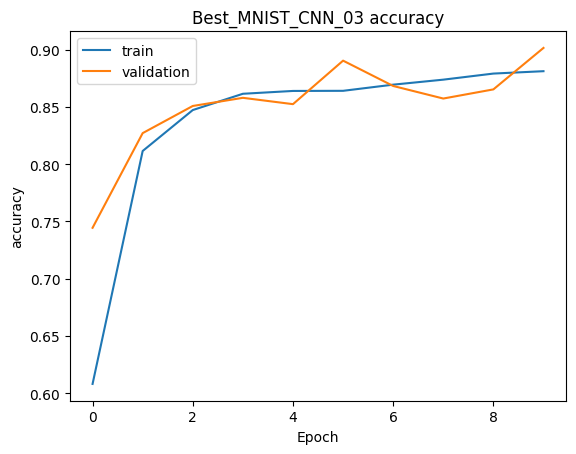

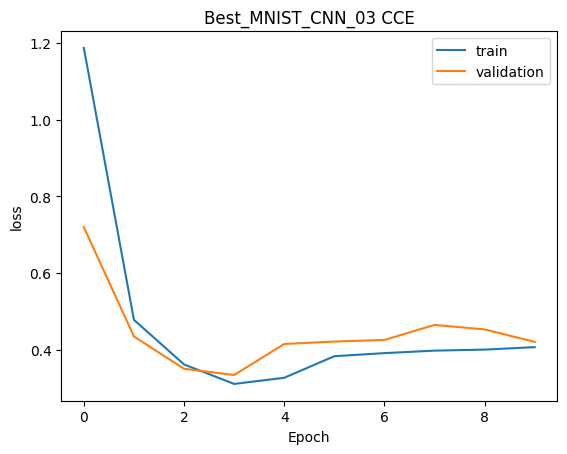

In [137]:
from radnn.plots import PlotLearningCurve

sPlotFileName = oFileSys.models.file(f'{oConfig.experiment_code}-LearningCurve-%s.png')
oPlot = PlotLearningCurve(oHistory, oConfig.experiment_code)
oPlot.prepare().save(sPlotFileName % "Accuracy").show()
oPlot.prepare_cost("CCE").save(sPlotFileName % "CCE").show()

In [138]:
nPredictedProbabilities = oCNN.predict(oData.VSFeed)
nPredictedClassLabels  = np.argmax(nPredictedProbabilities, axis=1)

nTargetClassLabels     = oEMNIST.VSLabels

for nIndex, nProbs in enumerate(nPredictedProbabilities):
  if nIndex < 10:
    print("#%.2d Predicted:%d (Probabilities:%s) Actual:%d" % (nIndex+1, nPredictedClassLabels[nIndex], nProbs, nTargetClassLabels[nIndex])) # [PYTHON] Format string example
    print("  |__ Sum of all output neuron activations:%.3f" % np.sum(nProbs))




208/208 [==============================] - 1s 4ms/step
#01 Predicted:1 (Probabilities:[6.4733289e-03 8.8270056e-01 9.6831570e-04 5.6591430e-03 1.2357398e-03
 2.2513745e-02 1.3077512e-03 7.7457572e-03 3.1841560e-03 1.5273786e-03
 1.3591549e-03 5.4547605e-03 4.3522916e-04 8.0396784e-03 7.9142125e-03
 4.7147521e-03 1.7339482e-03 5.4929103e-03 5.9014745e-03 1.5829842e-03
 4.8675947e-03 9.9947890e-03 1.7219944e-03 3.5599966e-03 2.4640472e-03
 1.4465703e-03]) Actual:1
  |__ Sum of all output neuron activations:1.000
#02 Predicted:1 (Probabilities:[2.7516684e-03 9.6102959e-01 8.5242547e-04 1.7393227e-03 6.6054397e-04
 5.6375265e-03 1.7235290e-03 1.6772372e-03 3.3769493e-03 9.5387042e-04
 2.6687066e-04 8.3771133e-04 2.9005829e-04 1.4390972e-03 2.1359520e-03
 1.3806297e-03 2.2669011e-03 1.1754455e-03 3.6859002e-03 9.7285496e-04
 1.5900260e-03 5.5706140e-04 2.0051839e-04 1.9903870e-03 6.6550315e-04
 1.4234663e-04]) Actual:1
  |__ Sum of all output neuron activations:1.000
#03 Predicted:1 (Probab

In [139]:
from radnn.evaluation import EvaluateClassification

# We create an evaluator object that will produce several metrics
oEvaluator = EvaluateClassification(nTargetClassLabels, nPredictedClassLabels)
oEvaluator.print_per_class()
oEvaluator.print_overall()
oEvaluator.print_confusion_matrix()

                            |   1    |   2    |   3    |   4    |   5    |   6    |   7    |   8    |   9    |  10    |  11    |  12    |  13    |  14    |  15    |  16    |  17    |  18    |  19    |  20    |  21    |  22    |  23    |  24    |  25    |  26   |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Per Class Recall %          | 0.00   | 90.88  | 90.25  | 91.38  | 89.62  | 95.88  | 92.38  | 68.38  | 91.12  | 76.12  | 90.25  | 94.38  | 72.75  | 96.50  | 90.38  | 96.12  | 96.25  | 80.12  | 92.75  | 95.12  | 97.25  | 94.62  | 89.50  | 95.12  | 94.25  | 93.50  | 0.00  |
Per Class Precision %       | 0.00   | 80.87  | 96.14  | 96.31  | 91.92  | 88.36  | 95.35  | 83.38  | 89.67  | 70.65  | 94.13  | 92.75  | 75.19  | 94.84  | 91.17  | 90.79  | 96.49  | 74.36  | 91.95  | 9

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_